# NSQIP Reproducibility Project
### Attempted Reproduction of "A Comparative Analysis of Readmission Rates After Outpatient Cosmetic Surgery" (Mioton et al, ASJ 2014)
### DOI: 10.1177/1090820X13519796

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency, fisher_exact
import statsmodels.api as sm

## *Excerpt from Methods (Mioton et al.)*

### Study Population
A review of the 2011 NSQIP data set was performed for all patients with “Plastics” recorded as their surgical specialty. Current Procedural Terminology (CPT) codes correlating with a list of the most common cosmetic procedures published by ASAPS were used to isolate cosmetic surgery cases. The specific surgical procedures captured in this analysis included liposuction, mastopexy, breast augmentation, reduction mammaplasty, abdominoplasty, rhinoplasty, brachioplasty, buttock lift, upper thigh lift, and blepharoplasty. All cases with a cosmetic CPT code were included in the analysis.

#### **1. Start by accessing 2011 NSQIP data.**

In [2]:
df = pd.read_csv("NSQIP_data/ACS_NSQIP_PUF11_TXT.txt", sep='\t', na_values=["NULL", -99], low_memory=False)
df[:5]

,CaseID,SEX,RACE_NEW,ETHNICITY_HISPANIC,PRNCPTX,CPT,WORKRVU,INOUT,TRANST,Age,...,READMISSION,UNPLANREADMISSION,REOPERATION,STILLINHOSP,SSSIPATOS,DSSIPATOS,OSSIPATOS,PNAPATOS,UTIPATOS,VENTPATOS
0,1229407,female,White,Yes,LAPS RPR RECURRENT INCISIONAL HERNIA REDUCIBLE,49656,15.08,Inpatient,Not transferred (admitted from home),69,...,No,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1229408,female,White,No,CLSR NTRSTM LG/SM INT,44620,14.43,Inpatient,Not transferred (admitted from home),49,...,No,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1229409,male,White,No,RPR UMBILICAL HRNA 5 YRS/> RDC,49585,6.59,Outpatient,Not transferred (admitted from home),48,...,No,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1229410,male,White,Yes,LAPAROSCOPY REPAIR INCISIONAL HERNIA REDUCIBLE,49654,15.03,Inpatient,Not transferred (admitted from home),72,...,No,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1229411,female,White,Yes,MAST MODF RAD W/AX LYMPH NOD W/WO PECT/ALIS MIN,19307,18.23,Inpatient,Not transferred (admitted from home),49,...,No,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **2. Subset to "Plastics" as the surgical specialty.**

In [3]:
df_plastics = df[df.SURGSPEC == "Plastics"]
print(f"There are {df_plastics.shape[0]} Plastics cases.")

There are 10678 Plastics cases.


#### **3. Subset by outpatient status**

#### Reproduction Uncertainty
*Outpatient status is implied in the Introduction and Results, but not mentioned in the Methods section.*

**Decision:** Will proceed with filtering by outpatient status in both cosmetics cases and non-Plastics cases for comparison

In [4]:
df_plastics_outpatient = df_plastics[df_plastics.INOUT=="Outpatient"]
df_outpatient = df[df.INOUT=="Outpatient"]

print(f"Across all specialties there are {df_outpatient.shape[0]} outpatient cases.")
print(f"There are {df_plastics_outpatient.shape[0]} outpatient, Plastics cases.")

Across all specialties there are 153228 outpatient cases.
There are 7005 outpatient, Plastics cases.


#### **4. Identify cosmetic procedures by CPT code**

#### Reproduction Uncertainty
*Exact CPT codes were not provided in the manuscript. Instead a list of cosmetic procedures was given.*

**Decision**: Cosmetic CPT codes were externally chosen based on list of procedures. 

- liposuction: 15876, 15877, 15878, 15879
- mastopexy: 19316
- breast augmentation: 19325
- breast reduction: 19318
- abdominoplasty: 15847, 15830
- rhinoplasty: 30400, 30410, 30420, 30430, 30435, 30450
- brachioplasty: 15836
- buttock lift: 20926
- upper thigh lift: 15832
- blepharoplasty: 15820, 15821, 15822, 15823

#### Reproduction Uncertainty
*There are multiple CPT columns that refer to the primary or additional CPT codes within a procedure. It was not specified whether the cosmetic CPT needed to be the primary CPT code.*

In [5]:
cpt_columns = [
   "CPT", "OTHERCPT1", "OTHERCPT2", "OTHERCPT3", "OTHERCPT4", "OTHERCPT5",
   "OTHERCPT6", "OTHERCPT7", "OTHERCPT8", "OTHERCPT9", "OTHERCPT10",
   "CONCPT1", "CONCPT2", "CONCPT3", "CONCPT4", "CONCPT5", "CONCPT6",
   "CONCPT7", "CONCPT8", "CONCPT9", "CONCPT10"
]

# Function to clean CPT codes
def clean_cpt(code):
    if pd.isnull(code):
        return ''
    code_str = str(code).strip().split('-')[0].split('.')[0]
    return code_str  

# Apply cleaning to all CPT columns in each dataset
for col in cpt_columns:
    df_plastics_outpatient.loc[:,col] = df_plastics_outpatient[col].apply(clean_cpt)

In [7]:
cosmetic_cpt_codes = ['15876','15877','15878','15879','19316','19325','19318',
                     '15830','15847','30400','30410','30420','30430','30435',
                     '30450','15836','20926','15832','15820','15821','15822','15823']

cpt_mask = df_plastics_outpatient[cpt_columns].isin(cosmetic_cpt_codes).any(axis=1)
#df_cosmetics = df_plastics[ cpt_mask ]

primary_cpt_mask = df_plastics_outpatient['CPT'].isin(cosmetic_cpt_codes)
df_cosmetics_outpatient = df_plastics_outpatient[primary_cpt_mask]

print(f"If checking only the primary CPT code, there are {sum(primary_cpt_mask)} cosmetic cases.")
print(f"If checking all CPT code columns, there are {sum(cpt_mask)} cosmetic cases.")
      
#print("\nWill proceed with all CPT code columns.")

If checking only the primary CPT code, there are 2586 cosmetic cases.
If checking all CPT code columns, there are 3164 cosmetic cases.


**Decision:** Investigator A chose to use only the primary CPT code for 2,586 cases. Investigator B chose to use all CPT codes for a total of 3,164 cases.

## *Excerpt from Methods*

### Outcome Measures
The primary outcome of interest was unplanned readmission. The 2011 NSQIP data set includes 2 newly incorporated variables to  track different readmissions: (1) the variable entitled “readmission” represents all-cause readmission, meaning readmission (to the same or another hospital) for any reason in the 30-day period after the index surgery, and (2) the variable entitled unplanned readmission” is defined as “readmission (to the same or another hospital) for a postoperative occurrence likely related to the principal surgical procedure” within 30 days of the procedure. We utilized the unplanned readmission variable to calculate readmission rates and provide a more focused investigation of the predictors of readmission.

“Surgical complication” was defined as having ≥1 of the following NSQIP postoperative adverse events: superficial surgical site infection (SSI), deep SSI, organ/space SSI, wound disruption/dehiscence, or graft/prosthesis failure. Medical complications included pneumonia, unplanned intubation, pulmonary embolism, failure to wean from a ventilator, renal insufficiency, progressive renal failure, urinary tract infection, stroke, coma, peripheral neurologic deficiency, cardiac arrest, myocardial infarction, bleeding requiring a transfusion, deep venous thrombosis (DVT), and sepsis or septic shock.

#### **1. Separate readmitted vs. non-readmitted cases.**

In [7]:
df_cosmetics_outpatient.UNPLANREADMISSION.value_counts()

UNPLANREADMISSION
Yes    46
No     45
Name: count, dtype: int64

In [8]:
print(f"There are {df_cosmetics_outpatient.shape[0]} outpatient cosmetics cases.")
print(f"There are {df_cosmetics_outpatient.UNPLANREADMISSION.isna().sum()} outpatient cosmetics cases with an NA in the UNPLANREADMISSION.")

There are 2586 outpatient cosmetics cases.
There are 2495 outpatient cosmetics cases with an NA in the UNPLANREADMISSION.


#### Reproduction Uncertainty
*The UNPLANREADMISSION column contains a lot of NAs. Out of 2,586 outpatient cosmetic cases, there are 2,495 without information in the unplanned readmission columns, only leaving 91 cases. 45 of 2,586 cases have "No" in the readmission column.*

**Decision:** Both Investigators A and B assumed that "NA" referred to no readmission. 

In [9]:
#Replace NA with "No" in the UNPLANREADMISSION column
df_cosmetics_outpatient = df_cosmetics_outpatient.copy()
df_cosmetics_outpatient.UNPLANREADMISSION.fillna("No", inplace=True)

df_readmitted = df_cosmetics_outpatient[(df_cosmetics_outpatient.UNPLANREADMISSION == "Yes") ]
df_not_readmitted = df_cosmetics_outpatient[(df_cosmetics_outpatient.UNPLANREADMISSION == "No") ]
assert df_readmitted.shape[0] + df_not_readmitted.shape[0] == df_cosmetics_outpatient.shape[0]

print(f"{df_readmitted.shape[0]} outpatient cosmetic cases were readmitted.")
print(f"{df_not_readmitted.shape[0]} outpatient cosmetic cases were not readmitted.")

46 outpatient cosmetic cases were readmitted.
2540 outpatient cosmetic cases were not readmitted.


#### **2. Define surgical complications for cases with and without readmission**

- Identified columns of interest:

| Complication    | Column |
| -------- | ------- |
| Superficial SSI | SUPINFEC|
| Deep SSI        | WNDINFD |
| Organ/Space SSI | ORGSPCSSI|
| Wound disruption/dehiscence|DEHIS|
| Graft/prosthesis failure|OTHGRAFL|  

<br />

- Converted all columns to "Yes|No" for easier processing.
- Added new surgical complication (SURG_COMPLICATION) column to identify prescence of any of the surgical complications.

In [10]:
#Ensure copies to avoid SettingWithCopyWarning
df_readmitted = df_readmitted.copy()
df_not_readmitted = df_not_readmitted.copy()

# Mapping of source columns to (new binary column, value to match)
complications = {
    "SUPINFEC":   ("SUPINFEC_BINARY", "Superficial Incisional SSI"),
    "WNDINFD":    ("WNDINFD_BINARY", "Deep Incisional SSI"),
    "ORGSPCSSI":  ("ORGSPCSSI_BINARY", "Organ/Space SSI"),
    "DEHIS":      ("DEHIS_BINARY", "Wound Disruption"),
    "OTHGRAFL":   ("OTHGRAFL_BINARY", "Graft/Prosthesis/Flap Failure")
}

# List of dataframes to process
dfs = [df_readmitted, df_not_readmitted]

# Assert that there are no NAs in the complications columns.
for df in dfs:
    for col in complications.keys():
        assert not df[col].isna().any(), f"Column {col} contains NA values."

# Process each dataframe
for df in dfs:
    # Create binary columns based on matching condition
    for col, (binary_col, match_value) in complications.items():
        df.loc[:, binary_col] = np.where(df[col] == match_value, "Yes", "No")
    
    # List of binary complication column names
    surg_columns = [binary for binary, _ in complications.values()]
    
    # Create overall surgical complication column based on any Yes in surg_columns
    df.loc[:, "SURG_COMPLICATION"] = np.where(
        df[surg_columns].eq("Yes").any(axis=1),
        "Yes",
        "No"
    )


#### Reproduction Uncertainty
*Reoperation rate was discussed in the Results, but not described as an included variable in the Surgical complications category.*

*Additionally, there are two reoperation variables. RETURNOR describes all planned and unplanned return to the operating room. REOPERATION includes only unplanned return to the operating room. Methods do not specify which variable was used.*

**Decision:** Reoperation rate will be kept separate from the "Surgical complications" category. The REOPERATION variable will be used. 

In [11]:
print(f"""There are {df_not_readmitted['REOPERATION'].isna().sum() +
                   df_readmitted['REOPERATION'].isna().sum()} cases with missing REOPERATION variable.""")

There are 87 cases with missing REOPERATION variable.


#### Reproduction Uncertainty
*No discussion was made about cases with missing variables.*

**Decision:** We will exclude the cases with a missing REOPERATION variable. 

In [12]:
df_not_readmitted.dropna(subset=["REOPERATION"], inplace=True)
df_readmitted.dropna(subset=["REOPERATION"], inplace=True)

df_readmitted.loc[:, "REOPERATION_BINARY"] = np.where(
    df_readmitted["REOPERATION"] == "Yes",
    "Yes",
    "No"
)

df_not_readmitted.loc[:, "REOPERATION_BINARY"] = np.where(
    df_not_readmitted["REOPERATION"] == "Yes",
    "Yes",
    "No"
)

#### **2. Define medical complications for cases with and without readmission**


- Identified columns of interest:

| Complication    | Column |
| -------- | ------- |
| Pneumonia | OUPNEUMO|
| Unplanned intubation  | REINTUB |
| Pulmonary embolism | PULEMBOL|
| Failure to wean from ventilator|FAILWEAN|
| Renal insufficiency |RENAINSF|
| Progressive renal failure|OPRENAFL|  
| Urinary tract infection|URNINFEC|  
| Stroke|CNSCVA|
| Coma|CNSCOMA|  
| Peripheral neurologic deficiency|NEURODEF|  
| Cardiac arrest|CDARREST| 
| Myocardial infarction|CDMI|  
| Bleeding requiring a transfusion|OTHBLEED|  
| Deep venous thrombosis|OTHDVT|  
| Sepsis|OTHSYSEP|  
| Septic shock|OTHSESHOCK|

<br />

- Converted all columns to "Yes|No" for easier processing.  
- Added new medical complication (MED_COMPLICATION) column to identify prescence of any of the medical complications.

In [13]:
# Ensure the dataframes are copies to avoid SettingWithCopyWarning
df_readmitted = df_readmitted.copy()
df_not_readmitted = df_not_readmitted.copy()

# Mapping of source columns to (new binary column, value to match)
medical_complications = {
    "OUPNEUMO":  ("OUPNEUMO_BINARY",  "Pneumonia"),
    "REINTUB":   ("REINTUB_BINARY",   "Unplanned Intubation"),
    "PULEMBOL":  ("PULEMBOL_BINARY",  "Pulmonary Embolism"),
    "FAILWEAN":  ("FAILWEAN_BINARY",  "On Ventilator greater than 48 Hours"),
    "RENAINSF":  ("RENAINSF_BINARY",  "Progressive Renal Insufficiency"),
    "OPRENAFL":  ("OPRENAFL_BINARY",  "Acute Renal Failure"),
    "URNINFEC":  ("URNINFEC_BINARY",  "Urinary Tract Infection"),
    "CNSCVA":    ("CNSCVA_BINARY",    "Stroke/CVA"),
    "CNSCOMA":   ("CNSCOMA_BINARY",   "Coma greater than 24 hours"),
    "NEURODEF":  ("NEURODEF_BINARY",  "Peripheral nerve injury"),
    "CDARREST":  ("CDARREST_BINARY",  "Cardiac Arrest Requiring CPR"),
    "CDMI":      ("CDMI_BINARY",      "Myocardial Infarction"),
    "OTHBLEED":  ("OTHBLEED_BINARY",  "Transfusions/Intraop/Postop"),
    "OTHDVT":    ("OTHDVT_BINARY",    "DVT Requiring Therapy"),
    "OTHSYSEP":  ("OTHSYSEP_BINARY",  "Sepsis"),
    "OTHSESHOCK":("OTHSESHOCK_BINARY","Septic Shock")
}

# List of dataframes to process
dfs = [df_readmitted, df_not_readmitted]

# Assert that there are no NAs in the original columns for each dataframe
for df in dfs:
    for col in medical_complications.keys():
        assert not df[col].isna().any(), f"Column {col} contains NA values."

# Process each dataframe
for df in dfs:
    # Create binary columns based on the matching condition
    for col, (binary_col, match_value) in medical_complications.items():
        df.loc[:, binary_col] = np.where(df[col] == match_value, "Yes", "No")
    
    # List of new binary column names for medical complications
    med_columns = [binary for binary, _ in medical_complications.values()]
    
    # Create overall medical complication column if any of the binary columns is "Yes"
    df.loc[:, "MED_COMPLICATION"] = np.where(
        df[med_columns].eq("Yes").any(axis=1),
        "Yes",
        "No"
    )


Additional column added for total complications. Cases that had a medical or surgical complication or a reoperation were included.  

In [14]:
##total complications
comp_columns = [
    "MED_COMPLICATION",
    "SURG_COMPLICATION",
    "REOPERATION_BINARY"
]

df_readmitted.loc[:, "TOTAL_COMPLICATION"] = np.where(
    df_readmitted[comp_columns].eq("Yes").any(axis=1),
    "Yes",
    "No"
)

df_not_readmitted.loc[:, "TOTAL_COMPLICATION"] = np.where(
    df_not_readmitted[comp_columns].eq("Yes").any(axis=1),
    "Yes",
    "No"
)

## *Excerpt from Methods*

### Risk-Adjustment Factors
Patient demographics and medical comorbidities were tracked as potential confounders. Demographic data included age and sex. Medical comorbidities included diabetes, dyspnea, ascites, renal disease, chronic obstructive pulmonary disease, current pneumonia, ventilator dependence, chronic steroid use, bleeding disorders, heart failure, and coronary disease (myocardial infarction within 6 months of operation, angina, previous coronary intervention, or surgery), as well as cerebrovascular disease (previous transient ischemic attack or stroke), peripheral vascular disease, disseminated cancer, weight loss of >10% body weight within 6 months of operation, current chemotherapy or radiotherapy, preoperative transfusion, and preoperative sepsis. Alcohol use (defined as >2 drinks per day) and active smoking status were tracked as behavioral risk factors.

#### **1. Define demographic variables and find appropriate data columns**

- Identified columns of interest:

| Complication    | Column |
| -------- | ------- |
| Age | Age |
| BMI | HEIGHT, WEIGHT |
| Diabetes | DIABETES |
| Dyspnea | DYSPNEA |
| Ascites | ASCITES |
| Renal disease | DIALYSIS, RENAFAIL |
| Chronic obstructive pulmonary disease | HXCOPD |
| Current pneumonia | CPNEUMON |
| Ventilator dependence | VENTILAT |
| Chronic steroid use |STEROID |
| Bleeding disorders | BLEEDDIS|
| Heart failure | HXCHF |
| Peripheral vascular disease |HXPVD|
| Disseminated cancer |DISCANCR|
| Weight loss >10% |WTLOSS|
| Current chemotherapy |CHEMO|
| Current radiotherapy |RADIO|
| Preoperative transfusion |TRANSFUS|
| Preoperative sepsis |PRSEPIS|
    

- Coronary disease columns:

| Complication    | Column |
| -------- | ------- |
|Myocardial infraction within 6 mos |HXMI |
| Angina | HXANGINA|
| Previous coronary intervention | PRVPCI |
| Surgery |PRVPCS |

- Cerebrovascular disease columns:

| Complication    | Column |
| -------- | ------- |
| Previous transient ischemic attack | HXTIA|
| Stroke |CVA, CVANO|

- Behavioral risk factor columns:

| Complication    | Column |
| -------- | ------- |
|Alcohol use|ETOH|
|Active smoking|SMOKE|


#### Reproduction Uncertainty
*Methods do not describe how to handle missing data*

**Decision:** All cases with any missing demographic or comorbidities will be excluded. 

In [15]:
# Define columns of interest in one line
columns_of_interest = ["Age", "HEIGHT", "WEIGHT", "DIABETES", "DYSPNEA", "ASCITES", "DIALYSIS", "RENAFAIL", "HXCOPD", "CPNEUMON", "VENTILAT", "STEROID", "BLEEDDIS", "HXCHF", "HXPVD", "DISCANCR", "WTLOSS", "CHEMO", "RADIO", "TRANSFUS", "HXMI", "HXANGINA", "PRVPCI", "PRVPCS", "HXTIA", "CVA", "CVANO", "ETOH", "SMOKE"]

# Count the number of rows that have at least one NA among these columns
rows_with_na = df_not_readmitted[columns_of_interest].isna().any(axis=1).sum() + df_readmitted[columns_of_interest].isna().any(axis=1).sum()
print(f"Number of rows that would be dropped: {rows_with_na}")

Number of rows that would be dropped: 1198


In [16]:
print(f"Before checking NAs, there are {df_not_readmitted.shape[0]} cosmetic cases that were not readmitted.")
print(f"Before checking NAs, there are {df_readmitted.shape[0]} cosmetic cases that were readmitted.")

df_not_readmitted = df_not_readmitted.dropna(subset=columns_of_interest)
df_readmitted = df_readmitted.dropna(subset=columns_of_interest)

print(f"\nAfter dropping NAs, there are {df_not_readmitted.shape[0]} cosmetic cases that were not readmitted.")
print(f"After dropping NAs, there are {df_readmitted.shape[0]} cosmetic cases that were readmitted.")


Before checking NAs, there are 2453 cosmetic cases that were not readmitted.
Before checking NAs, there are 46 cosmetic cases that were readmitted.

After dropping NAs, there are 1274 cosmetic cases that were not readmitted.
After dropping NAs, there are 27 cosmetic cases that were readmitted.


#### **2. Clean variables**

#### Reproduction Uncertainty
*For two variables, "renal disease" and "stroke" there are multiple columns. Renal disease could refer to the patient currently on dialysis (DIALYSIS column) or the patient is in acute renal failure (RENAFAIL column). For stroke, there are two columns, CVA and CVANO in which the patient has a history of stroke/CVA with and without persistent neurological deficits. The specific column used for both variables is not specified.*

**Decision:** For renal disease, presence of either dialysis or acute renal failure will be considered. Similarly for stroke, both CVA and CVANO will be considered.  

In [17]:
# Ensure the dataframes are copies to avoid SettingWithCopyWarning
df_readmitted = df_readmitted.copy()
df_not_readmitted = df_not_readmitted.copy()

# List of dataframes for processing
dfs = [df_readmitted, df_not_readmitted]

# ----- Single-column transformations -----
# Mapping for columns with direct "Yes/No" logic:
# - For DIABETES, we check if the value is either "INSULIN" or "NON-INSULIN".
# - For DYSPNEA, we check if value is either "AT REST" or "MODERATE EXERTION"
# - For ASACLAS, we check if the value is in ["3-Severe Disturb", "4-Life Threat"].
single_col_mappings = {
    "DIABETES": {"binary_col": "DIABETES_BINARY", "yes_vals": ["INSULIN", "NON-INSULIN"]},
    "DYSPNEA" : {"binary_col": "DYSPNEA_BINARY", "yes_vals": ["AT REST", "MODERATE EXERTION"]},
    "ASACLAS":  {"binary_col": "ASACLAS_BINARY",    "yes_vals": ["3-Severe Disturb", "4-Life Threat"]}
}

# Assert no NAs in these original columns and apply the transformation
for df in dfs:
    for col, mapping in single_col_mappings.items():
        assert not df[col].isna().any(), f"Column {col} contains NA values."
        df.loc[:, mapping["binary_col"]] = np.where(
            df[col].isin(mapping["yes_vals"]),
            "Yes",
            "No"
        )

# ----- Multiple-column (aggregated) transformations -----
# Renal failure
renal_columns = ["DIALYSIS", "RENAFAIL"]
# Coronary disease
coronary_columns = ["HXMI", "HXANGINA", "PRVPCI", "PRVPCS"]
# Cerebrovascular disease
brain_columns = ["HXTIA", "CVA", "CVANO"]

# Assert no NAs in the coronary and brain columns
for df in dfs:
    for col in renal_columns:
        assert not df[col].isna().any(), f"Column {col} contains NA values."
    for col in coronary_columns:
        assert not df[col].isna().any(), f"Column {col} contains NA values."
    for col in brain_columns:
        assert not df[col].isna().any(), f"Column {col} contains NA values."
    

# Apply aggregated transformation for coronary and brain conditions
for df in dfs:
    df.loc[:, "RENAL_BINARY"] = np.where(
        df[renal_columns].eq("Yes").any(axis=1),
        "Yes",
        "No"
    )
    df.loc[:, "CORONARY_BINARY"] = np.where(
        df[coronary_columns].eq("Yes").any(axis=1),
        "Yes",
        "No"
    )
    df.loc[:, "BRAIN_BINARY"] = np.where(
        df[brain_columns].eq("Yes").any(axis=1),
        "Yes",
        "No"
    )


Calcualte BMI with the following standard formula:
- weight / height ^2 * 703

In [18]:
df_readmitted['BMI'] = (df_readmitted.WEIGHT / (df_readmitted.HEIGHT ** 2)) * 703
df_not_readmitted['BMI'] = (df_not_readmitted.WEIGHT / (df_not_readmitted.HEIGHT ** 2)) * 703


## *Excerpt from Methods*
### Statistical Analysis
The unplanned readmission rate was calculated for outpatient cosmetic surgery cases, as well as the 5 other surgical disciplines with the highest number of reported outpatient procedures (general, orthopedic, gynecologic, urologic,
and otolaryngologic surgery). Subgroup analysis was performed on the 5 most common outpatient cosmetic surgery procedures captured in the NSQIP database: reduction mammaplasty, mastopexy, breast augmentation, liposuction, and abdominoplasty. Patient demographics, risk factors, and postoperative outcomes were tracked for readmitted and non-readmitted patients. Chi-square analysis and the Student t test were used to compare categorical and continuous variables, respectively. 

### Figure 1: Analyze unplanned readmission rates by surgical specialty

#### Reproduction Uncertainty
*As previously discussed, the UNPLANREADMISSION column contains a lot of NAs.*

**Decision:** We will consider NAs as no unplanned readmission for all surgical specialties

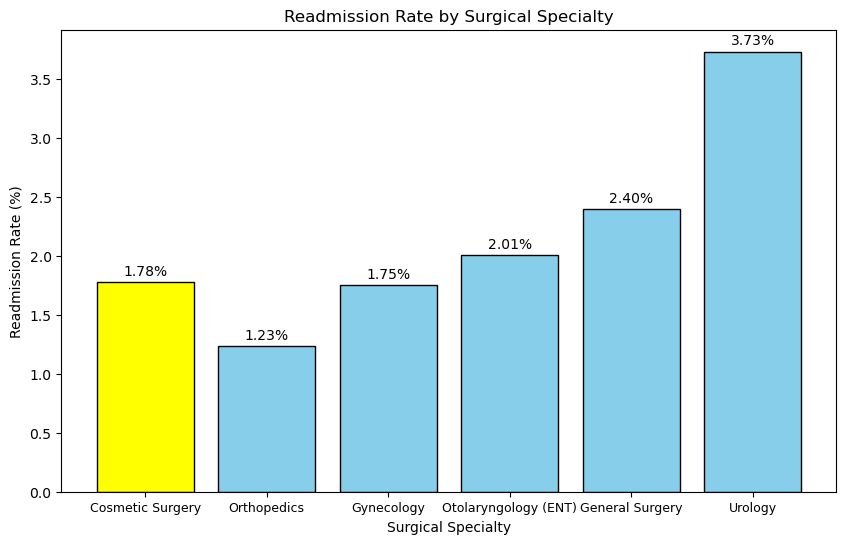

In [19]:
# Define the specialties of interest
specialties = ["Orthopedics", "Gynecology", "Otolaryngology (ENT)", "General Surgery", "Urology"]

# Subset the DataFrame to only include rows for the specialties of interest
df_subset = df_outpatient[df_outpatient["SURGSPEC"].isin(specialties)].copy()

# Treat NA in UNPLANREADMISSION as "No"
df_subset["UNPLANREADMISSION"] = df_subset["UNPLANREADMISSION"].fillna("No")

# Calculate the readmission rate for each specialty:
# Count rows with "Yes" and divide by the total rows in that specialty, then multiply by 100 for percentage.
readmission_rates = df_subset.groupby("SURGSPEC")["UNPLANREADMISSION"].apply(
    lambda x: (x == "Yes").sum() / len(x) * 100
)

# Reindex to ensure the order of the bars matches the desired specialty order
readmission_rates = readmission_rates.reindex(specialties)

# Now, calculate the readmission rate for cosmetic outpatients (from df_cosmetic_outpatient)
df_cosmetics_outpatient = df_cosmetics_outpatient.copy()  # make a copy to avoid warnings
cosmetic_rate = sum(df_cosmetics_outpatient["UNPLANREADMISSION"] == "Yes") / df_cosmetics_outpatient.shape[0] * 100

readmission_rates["Cosmetic Surgery"] = cosmetic_rate

# Define the new order: Cosmetic Surgery first, then the rest
new_order = ["Cosmetic Surgery"] + specialties
readmission_rates = readmission_rates.reindex(new_order)

# Define the colors: yellow for Cosmetic Surgery, skyblue for the rest
colors = ["yellow"] + ["skyblue"] * len(specialties)


# Create the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(readmission_rates.index, readmission_rates.values, color=colors, edgecolor="black")
for bar in bars:
    x = bar.get_x() + bar.get_width()/2
    y = bar.get_height()
    plt.annotate(f'{y:.2f}%', 
                 xy=(x, y), 
                 xytext=(0, 3),  # offset text 3 points above the bar
                 textcoords="offset points",
                 ha='center', va='bottom')
plt.xticks(fontsize=9) 
plt.xlabel("Surgical Specialty")
plt.ylabel("Readmission Rate (%)")
plt.title("Readmission Rate by Surgical Specialty")
plt.show()

### Figure 2. Analyze unplanned readmission rates by most common plastics procedures

#### Reproduction Uncertainty
*How are the most common plastics procedures chosen? 
Some options:*
- *By CPT code -- Principle CPT code vs. "Concurrent" vs. "Other"*
    - *What if one case has multiple cosmetic CPT codes listed. Ex: abdominoplasty and liposuction*
- *By the principle procedure column (PRNCPTX) -- Theoretically, should align with the principle CPT code.*


In [20]:
print("The top 5 most common outpatient cosmetic procedure by principle procedure column are:")
df_cosmetics_outpatient.PRNCPTX.value_counts()[:5]

The top 5 most common outpatient cosmetic procedure by principle procedure column are:


PRNCPTX
REDUCTION MAMMAPLASTY                              1501
MAMMAPLASTY AUGMENTATION W/PROSTHETIC IMPLANT       430
EXCISION SKIN ABD INFRAUMBILICAL PANNICULECTOMY     323
MASTOPEXY                                           244
EXCISION EXCESSIVE SKIN & SUBQ TISSUE ABDOMEN        45
Name: count, dtype: int64

In [ ]:
# Mapping of procedures to sets of CPT codes
procedure_codes = {
    'liposuction': {'15876', '15877', '15878', '15879'},
    'mastopexy': {'19316'},
    'breast augmentation': {'19325'},
    'breast reduction': {'19318'},
    'abdominoplasty': {'15847', '15830'},
    'rhinoplasty': {'30400', '30410', '30420', '30430', '30435', '30450'},
    'brachioplasty': {'15836'},
    'buttock lift': {'20926'},
    'upper thigh lift': {'15832'},
    'blepharoplasty': {'15820', '15821', '15822', '15823'}
}

# Reverse lookup: code -> procedure name
reverse_map = {code: procedure for procedure, codes in procedure_codes.items() for code in codes}

# Column groups in order of priority
primary_col = 'CPT'
concpt_cols = [f'CONCPT{i}' for i in range(1, 11)]
othercpt_cols = [f'OTHERCPT{i}' for i in range(1, 11)]

# Function to collect all matching procedures in a row
def get_all_procedures(row):
    
    #check primary cpt code first
    primary_code = str(row.get(primary_col, '')).strip()
    primary_proc = reverse_map.get(primary_code)
    
    return[primary_proc]


# Apply the function to get all procedures per patient
df_cosmetics_outpatient['AllProcedures'] = df_cosmetics_outpatient.apply(get_all_procedures, axis=1)


In [22]:
df_cosmetics_outpatient['FinalProcedure'] = df_cosmetics_outpatient['AllProcedures'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None
)

In [23]:
print("The top 5 most common outpatient cosmetic procedures by primary CPT code are:")
df_cosmetics_outpatient.FinalProcedure.value_counts()[:5]

The top 5 most common outpatient cosmetic procedures by primary CPT code are:


FinalProcedure
breast reduction       1501
breast augmentation     430
abdominoplasty          368
mastopexy               244
buttock lift             43
Name: count, dtype: int64

To be consistent with previous decisions, we will use the primary CPT codes. The codes are sorted into the procedures of interest. 

- liposuction: 15876, 15877, 15878, 15879
- mastopexy: 19316
- breast augmentation: 19325
- breast reduction: 19318
- abdominoplasty: 15847, 15830
- rhinoplasty: 30400, 30410, 30420, 30430, 30435, 30450
- brachioplasty: 15836
- buttock lift: 20926
- upper thigh lift: 15832
- blepharoplasty: 15820, 15821, 15822, 15823

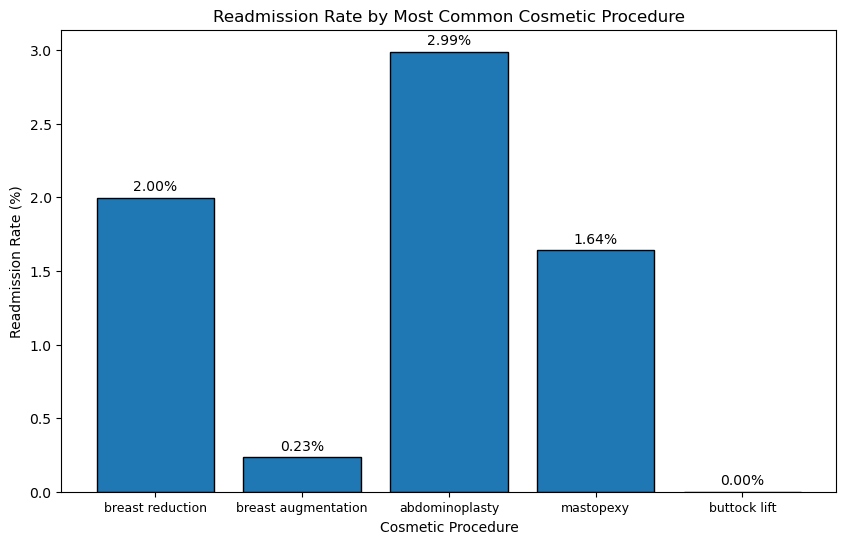

In [24]:
# Define the procedures of interest
top_procedures = df_cosmetics_outpatient.FinalProcedure.value_counts()[:5].index.tolist()

# Subset the DataFrame to only include rows for the specialties of interest
df_subset = df_cosmetics_outpatient[df_cosmetics_outpatient["FinalProcedure"].isin(top_procedures)].copy()

assert df_subset.UNPLANREADMISSION.isna().sum() == 0

# Calculate the readmission rate for each specialty:
# Count rows with "Yes" and divide by the total rows in that specialty, then multiply by 100 for percentage.
readmission_rates = df_subset.groupby("FinalProcedure")["UNPLANREADMISSION"].apply(
    lambda x: (x == "Yes").sum() / len(x) * 100
)

# Reindex to ensure the order of the bars matches the desired specialty order
readmission_rates = readmission_rates.reindex(top_procedures)


# Create the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(readmission_rates.index, readmission_rates.values, edgecolor="black")
for bar in bars:
    x = bar.get_x() + bar.get_width()/2
    y = bar.get_height()
    plt.annotate(f'{y:.2f}%', 
                 xy=(x, y), 
                 xytext=(0, 3),  # offset text 3 points above the bar
                 textcoords="offset points",
                 ha='center', va='bottom')
plt.xticks(fontsize=9) 
plt.xlabel("Cosmetic Procedure")
plt.ylabel("Readmission Rate (%)")
plt.title("Readmission Rate by Most Common Cosmetic Procedure")
plt.show()

### Table 1: Analyze demographic data between readmitted and not readmitted groups


Start with continuous variables (per Methods, use Student T-test)

In [25]:
final_table = []

df_readmitted["Age"] = pd.to_numeric(df_readmitted["Age"], errors="coerce")
df_not_readmitted["Age"] = pd.to_numeric(df_not_readmitted["Age"], errors="coerce")

cont_columns = ["Age", "BMI"]

cont_names = {
    "Age": "Age, mean ± SD, y",
    "BMI": "BMI, mean ± SD"
}


for cont_var in cont_columns:
    stat_readmit = f"{df_readmitted[cont_var].mean():.2f} ± {df_readmitted[cont_var].std():.2f}"
    stat_not_readmit = f"{df_not_readmitted[cont_var].mean():.2f} ± {df_not_readmitted[cont_var].std():.2f}"
    p_value = ttest_ind(df_readmitted[cont_var], df_not_readmitted[cont_var]).pvalue
    
    p_str = f"{p_value:.3f}" + ("*" if p_value < 0.05 else "")
    name = cont_names.get(cont_var, cont_var)
    final_table.append([name, stat_readmit, stat_not_readmit, p_str])
    

Add categorical variables (per Methods, use chi squared)

In [26]:
cat_columns = ["DIABETES_BINARY", "HYPERMED", "SMOKE", "ETOH", "DYSPNEA_BINARY", "CORONARY_BINARY", "BRAIN_BINARY", "ASACLAS_BINARY"]
cat_names = {
    "DIABETES_BINARY": "Diabetes",
    "HYPERMED": "Hypertension",
    "SMOKE": "Smoking",
    "ETOH": "Alcohol Use",
    "DYSPNEA_BINARY": "Dyspnea",
    "CORONARY_BINARY": "Coronary Disease",
    "BRAIN_BINARY": "Cerebrovascular disease",
    "ASACLAS_BINARY": "ASA class 3 or 4"
}

for cat in cat_columns:
        
    assert df_readmitted[cat].isna().sum() == 0
    assert df_not_readmitted[cat].isna().sum() == 0
    
    readmit_yes = sum( df_readmitted[cat] == "Yes" )
    readmit_total = df_readmitted[cat].shape[0]
    not_readmit_yes = sum( df_not_readmitted[cat] == "Yes" )
    not_readmit_total = df_not_readmitted[cat].shape[0]
    
    perc_readmitted = f"{(readmit_yes / readmit_total) * 100:.2f}"
    perc_not_readmitted = f"{(not_readmit_yes / not_readmit_total) * 100:.2f}"
    
    contingency_table = [[readmit_yes, readmit_total - readmit_yes],
                         [not_readmit_yes, not_readmit_total - not_readmit_yes]]

    if readmit_yes == 0 or not_readmit_yes == 0:
        p_value = 1.00
    else:    
        p_value = chi2_contingency(contingency_table)[1]
    
    p_str = f"{p_value:.3f}" + ("*" if p_value < 0.05 else "")
    name = cat_names.get(cat, cat)
    final_table.append([name, perc_readmitted, perc_not_readmitted, p_str])

In [27]:
final_table_df = pd.DataFrame(
    final_table, 
    columns=["Characteristic", f"Readmitted (n= {df_readmitted.shape[0]})", f"Not Readmitted (n= {df_not_readmitted.shape[0]})", "P-Value"]
)

final_table_df

,Characteristic,Readmitted (n= 27),Not Readmitted (n= 1274),P-Value
0,"Age, mean ± SD, y",49.15 ± 12.92,44.24 ± 13.70,0.065
1,"BMI, mean ± SD",34.38 ± 9.30,28.74 ± 6.21,0.000*
2,Diabetes,7.41,4.32,0.763
3,Hypertension,40.74,21.27,0.028*
4,Smoking,11.11,9.18,0.995
5,Alcohol Use,3.70,1.02,0.693
6,Dyspnea,7.41,1.49,0.101
7,Coronary Disease,7.41,0.94,0.023*
8,Cerebrovascular disease,0.00,0.63,1.000
9,ASA class 3 or 4,33.33,11.85,0.002*


### Table 2: Analyze outcomes between readmitted and not readmitted groups


In [28]:
comp_table = []

comp_cat_columns = ["TOTAL_COMPLICATION", "SURG_COMPLICATION","SUPINFEC_BINARY", "WNDINFD_BINARY", "ORGSPCSSI_BINARY", 
                    "DEHIS_BINARY", "MED_COMPLICATION", "REOPERATION"]
comp_cat_names = {
    "TOTAL_COMPLICATION": "Total complications",
    "SURG_COMPLICATION": "Surgical complications",
    "SUPINFEC_BINARY": "Superficial SSI",
    "WNDINFD_BINARY": "Deep SSI",
    "ORGSPCSSI_BINARY": "Organ/space SSI",
    "DEHIS_BINARY": "Wound dehiscence",
    "MED_COMPLICATION": "Medical complications",
    "REOPERATION": "Reoperation"
}

for cat in comp_cat_columns:
    
    readmit_yes = sum( df_readmitted[cat] == "Yes" )
    readmit_total = df_readmitted[cat].shape[0]
    not_readmit_yes = sum( df_not_readmitted[cat] == "Yes" )
    not_readmit_total = df_not_readmitted[cat].shape[0]
    
    perc_readmitted = f"{(readmit_yes / readmit_total) * 100:.2f}"
    perc_not_readmitted = f"{(not_readmit_yes / not_readmit_total) * 100:.2f}"
    
    contingency_table = [[readmit_yes, readmit_total - readmit_yes],
                         [not_readmit_yes, not_readmit_total - not_readmit_yes]]

    if readmit_yes == 0 or not_readmit_yes == 0:
        p_value = 1.00
    else:    
        p_value = chi2_contingency(contingency_table)[1]

    p_str = f"{p_value:.3f}" + ("*" if p_value < 0.05 else "")
    name = comp_cat_names.get(cat, cat)
    comp_table.append([name, perc_readmitted, perc_not_readmitted, p_str])

In [29]:
final_table_df = pd.DataFrame(
    comp_table, 
    columns=["Characteristic", f"Readmitted (n= {df_readmitted.shape[0]}), %", f"Not Readmitted (n= {df_not_readmitted.shape[0]}), %", "P-Value"]
)

new_row = pd.DataFrame({
    "Characteristic": ["Wound infection"],
    f"Readmitted (n= {df_readmitted.shape[0]}), %": ['-'],
    f"Not Readmitted (n= {df_not_readmitted.shape[0]}), %": ['-'],
    "P-Value": ['-']
})


df_updated = pd.concat([final_table_df.iloc[:2], new_row, final_table_df.iloc[2:]], ignore_index=True)
df_updated

,Characteristic,"Readmitted (n= 27), %","Not Readmitted (n= 1274), %",P-Value
0,Total complications,74.07,3.69,0.000*
1,Surgical complications,44.44,2.90,0.000*
2,Wound infection,-,-,-
3,Superficial SSI,22.22,2.59,0.000*
4,Deep SSI,18.52,0.16,0.000*
5,Organ/space SSI,0.00,0.00,1.000
6,Wound dehiscence,3.70,0.16,0.076
7,Medical complications,29.63,0.47,0.000*
8,Reoperation,37.04,0.39,0.000*


## Excerpt from Methods
### Statistical Analysis (continued)

Multivariate logistic regression models were used to determine predictors of unplanned readmission. Individual variables with ≥10 event occurrences showing prediction of readmission at a significance level of ≤0.20 in bivariate analysis were included in the multivariable models. 

#### Reproduction Uncertainty
*Methods does not specify which variables were used in the initial bivariate logistic regression screening step. In the Results, two variables -- Obesity (BMI>=30) and operating time (hours) were found to be singificant in the initial screen.*

**Decision:** Investigator A chose to skip the screening step, and use obesity and operating time for a final multivariate regression model. 

#### **1. Identify and clean varaibles.**

In [30]:
df_combined_clean = pd.concat([df_readmitted, df_not_readmitted])
assert df_combined_clean.UNPLANREADMISSION.isna().sum() == 0

Create an obesity column based on BMI >= 30

In [31]:
df_combined_clean = df_combined_clean.copy()
df_combined_clean.loc[:, "OBESITY_BINARY"] = np.where(
    df_combined_clean["BMI"] >= 30,
    "Yes",
    "No"
)

Convert operating time (OPTIME) from minutes to hours. 

In [32]:
df_combined_clean["OPTIME_HRS"] = df_combined_clean.OPTIME / 60

#### **2. Create a multivariate logistic regression model using obesity and operating time**

In [33]:
# Define outcome and predictors
df_combined_clean["READMISSION_BINARY"] = np.where(df_combined_clean["UNPLANREADMISSION"] == "Yes", 1, 0)

y = df_combined_clean["READMISSION_BINARY"]

df_combined_clean["OBESITY_BINARY"] = np.where(df_combined_clean["OBESITY_BINARY"] == "Yes", 1, 0)

X = df_combined_clean[["OBESITY_BINARY", "OPTIME_HRS"]]  

X = sm.add_constant(X)

# Fit logistic regression
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.098365
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     READMISSION_BINARY   No. Observations:                 1301
Model:                          Logit   Df Residuals:                     1298
Method:                           MLE   Df Model:                            2
Date:                Tue, 25 Feb 2025   Pseudo R-squ.:                 0.02567
Time:                        12:43:50   Log-Likelihood:                -127.97
converged:                       True   LL-Null:                       -131.34
Covariance Type:            nonrobust   LLR p-value:                   0.03433
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.3141      0.491     -8.782      0.000      -5.277      -3.351
OBESITY_BINARY   

In [34]:
summary_text = (
    "Logistic regression analysis showed that obesity significantly increased the odds of unplanned readmission, "
    f"with a coefficient of {model.params['OBESITY_BINARY']:.4f} (p = {model.pvalues['OBESITY_BINARY']:.3f}) "
    f"and an odds ratio of approximately {np.exp(model.params['OBESITY_BINARY']):.2f}. "
    "This means that patients with obesity are "
    f"{np.exp(model.params['OBESITY_BINARY']):.2f} times more likely to be readmitted. "
    "In contrast, operative time was not a significant predictor of readmission "
    f"(coefficient = {model.params['OPTIME_HRS']:.4f}, p = {model.pvalues['OPTIME_HRS']:.3f}). "
    f"Finally, the model’s low Pseudo R-squared value ({model.prsquared:.4f}) "
    f"indicates that only about {model.prsquared * 100:.2f}% of the variation in readmission "
    "is explained by these predictors, suggesting that many other factors contribute to the risk of readmission."
)
print(summary_text)


Logistic regression analysis showed that obesity significantly increased the odds of unplanned readmission, with a coefficient of 1.0315 (p = 0.012) and an odds ratio of approximately 2.81. This means that patients with obesity are 2.81 times more likely to be readmitted. In contrast, operative time was not a significant predictor of readmission (coefficient = -0.0245, p = 0.883). Finally, the model’s low Pseudo R-squared value (0.0257) indicates that only about 2.57% of the variation in readmission is explained by these predictors, suggesting that many other factors contribute to the risk of readmission.
